# Insurance with Regression Model

#### Imported needed modules

In [69]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt


#### Reading information relevant to us from files

In [70]:
training_data = read_csv('files_for_train/train.csv')
test_data = read_csv('files_for_train/test.csv')

#### Data for the train kit

In [71]:
print(training_data.shape)
training_data.head()

(1200000, 21)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


#### Data for the test kit

In [72]:
print(test_data.shape)
test_data.head()

(800000, 20)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


#### Number of columns and names of these columns for both data sets

In [73]:
all_columns = training_data.columns.to_list()
print("Liczba kolumn: ")
print(len(all_columns))
print("Kolumny: ")
for column in all_columns:
    print(column)

Liczba kolumn: 
21
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type
Premium Amount


In [74]:
all_columns_tests = test_data.columns.to_list()
print("Liczba kolumn: ")
print(len(all_columns_tests))
print("Kolumny: ")
for test_column in all_columns_tests:
    print(test_column)

Liczba kolumn: 
20
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type


#### Data allocation

In [75]:
all_columns = training_data.iloc[:, :-1]
premium_amounts = training_data.iloc[:, -1]

#### The sum of null data for each column in the case of a test and training kit

In [76]:
training_data.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [77]:
test_data.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

#### Dividing data into categorical and numerical.

What are these types of data?
 - Numerical data - a type of data that consists of numbers and can be subjected to mathematical operations such as Age, Annual Income etc. 
 - Categorical data - represent sorts of data which can be divided into groups such as Marital Status, Gender etc

In [78]:
numerical_columns = all_columns.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = all_columns.select_dtypes(exclude=[np.number]).columns.tolist()

#### Filling categorical data with the word "Missing", and numerical data - average from all data from this type of column

In [79]:
training_data[numerical_columns] = training_data[numerical_columns].fillna(training_data[numerical_columns].mean())
training_data[categorical_columns] = training_data[categorical_columns].fillna("Missing")
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())
test_data[categorical_columns] = test_data[categorical_columns].fillna("Missing")

#### Checking after such cleaning the amount of null data in the columns 

In [80]:
training_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [81]:
test_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

#### Creating the xgb_model model to match your training data

In [82]:
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    enable_categorical=True
)

In [83]:
# xgb_model.fit(X_train, y_train)

#### Checking for outliers looking at box plots


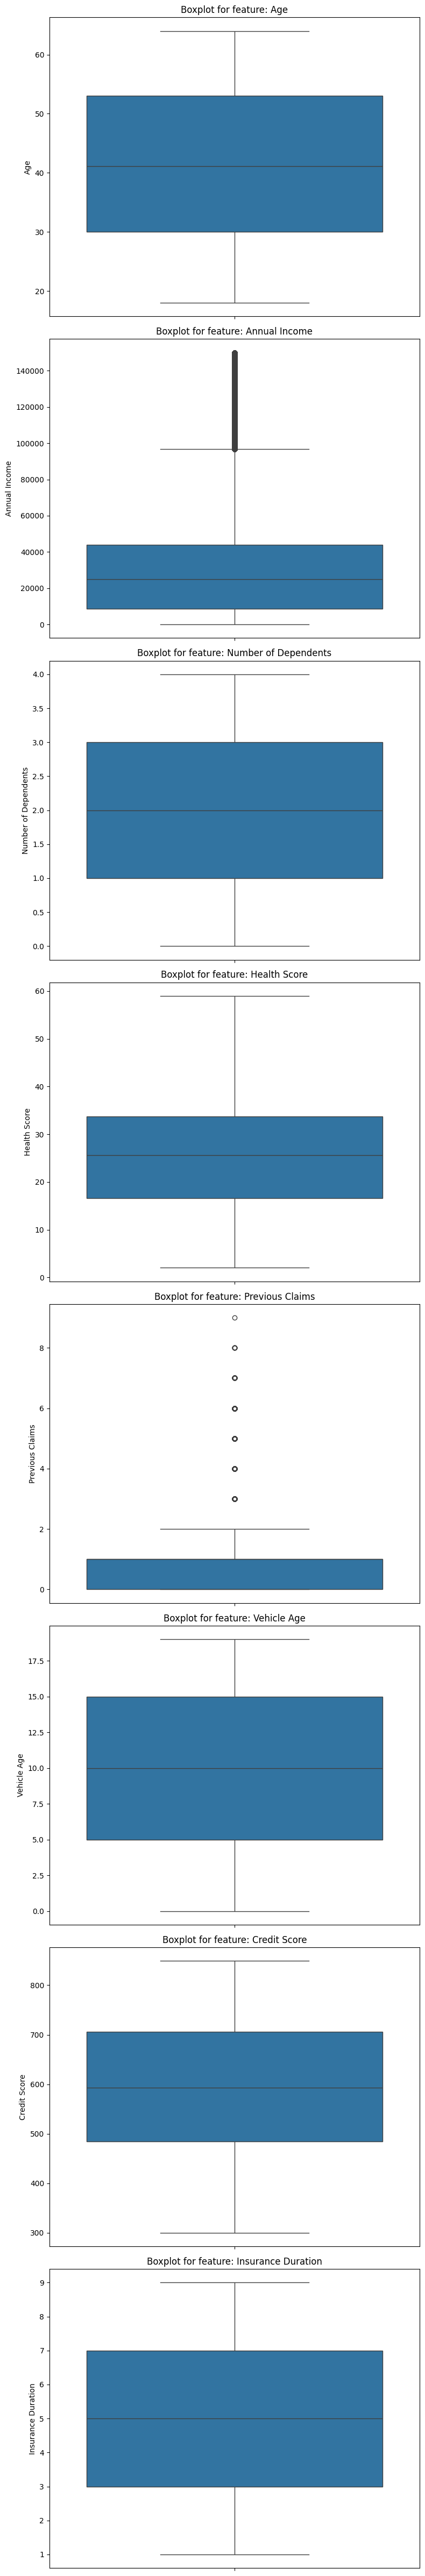

In [84]:

numerical_features = training_data.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=training_data[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()


Except "previous claims" and "annual income" features have normal distribution. Because those two features mantioned above have assimetrical distribution, we will try IQR method to get rid of outliers.

In [ ]:
Q1 = training_data[numerical_columns].quantile(0.25)
Q3 = training_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1


training_data_no_outliers = training_data[~((training_data[numerical_columns] < (Q1 - 1.5 * IQR)) |
                      (training_data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


NameError: name 'numeric_cols' is not defined

In [ ]:
numerical_features = training_data_no_outliers.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=training_data_no_outliers[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()
